In [252]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [253]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)
        print("Creating QAM constellation with {} bits per symbol".format(num_bits_per_symbol))
        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

In [254]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [255]:
NUM_BITS_PER_SYMBOL = 4 # QPSK: 2, QAM16
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape

Creating QAM constellation with 4 bits per symbol


(16,)

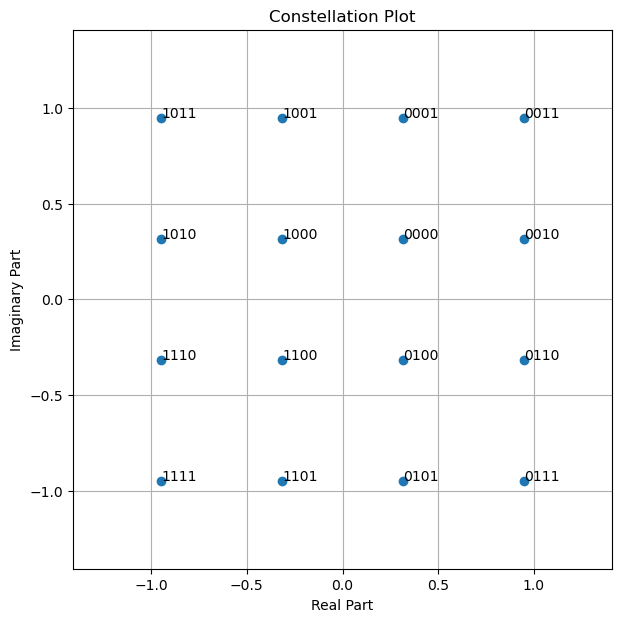

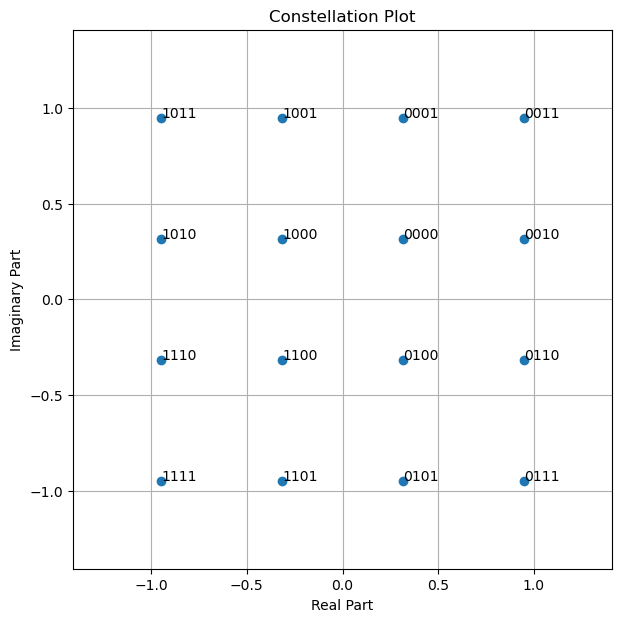

In [256]:
show(points, NUM_BITS_PER_SYMBOL)

In [257]:
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

In [258]:
def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

In [259]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

In [381]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

In [382]:
# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        print(self.points.shape) #(4,) complex64
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs
    
    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0) 
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch
    
    def __len__(self):
        return len(self.ebno_dbs)

In [383]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

Creating QAM constellation with 4 bits per symbol
(16,)
Creating QAM constellation with 4 bits per symbol


In [263]:
onesample = dataset[0]

In [264]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [265]:
onesample['samples'].shape

torch.Size([64, 256])

In [266]:
onesample['labels'].shape

(64, 1024)

In [267]:
# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [268]:
onebatch = next(iter(val_loader))

In [269]:
onebatch['samples'].shape

torch.Size([1, 64, 256])

In [270]:
onebatch = next(iter(train_loader))

In [271]:
onebatch['samples'].shape

torch.Size([32, 64, 256])

In [272]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [273]:
class Simplemodel(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[32,64,256]
        print(y.shape)
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 32, 64, 256]
        print(z.shape)
        z = z.permute(1, 2, 3, 0) #[32, 64, 256, 2]
        print("before linear1: ", z.shape)  # Print the shape after the convolutional layer

        z = self.linear1(z) #[32,64,256,32]
        print("After cnn1: ", z.shape)  # Print the shape after the convolutional layer

        z = self.activation(z)#[32,64,256,32]
        print("After activation: ", z.shape)
        z = self.linear2(z) #[32,64,256,4]
        print("After linear2: ", z.shape)
        z = nn.Sigmoid()(z) #[32,64,256,32]
        print("After sigmoid: ", z.shape)
        z = z.flatten(-2, -1) #[32, 64, 1024]
        print("After flatten: ", z.shape)
        return z

In [274]:
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [275]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

torch.Size([32, 64, 256])
torch.Size([2, 32, 64, 256])
before linear1:  torch.Size([32, 64, 256, 2])
After cnn1:  torch.Size([32, 64, 256, 32])
After activation:  torch.Size([32, 64, 256, 32])
After linear2:  torch.Size([32, 64, 256, 4])
After sigmoid:  torch.Size([32, 64, 256, 4])
After flatten:  torch.Size([32, 64, 1024])


Model1 + CNN

In [276]:
class Simplemodel1(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel1, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        scale = 8
        self.linear1=nn.Linear(in_features=4, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        # print("After cnn1: ", z.shape)  # Print the shape after the convolutional layer
        z = self.activation(z)
        # print("Before reshaping: ", z.shape)# [32, 2, 64, 256]

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.linear1(z)
        # print("After linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.activation(z)#[32,64,256,32]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer

        z = self.linear2(z)
        # print("After linear2: ", z.shape)  # Print the shape before the linear layer
        z = nn.Sigmoid()(z) #[32,64,256,32]

        # z = z.view(-1,32,4) #[batch_size, num_bits_per_symbol]
        # print("After model: ", z.shape)  # Print the shape before the linear layer

        return z

In [277]:
model1 = Simplemodel1(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [278]:
output = model1(onebatch['samples']) 


In [279]:
output.shape

torch.Size([32, 64, 256, 4])

In [280]:
output.dtype

torch.float32

In [281]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [282]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [283]:
loss_fn(test,test)

tensor(0.)

In [284]:
onebatch['labels'] = onebatch['labels'].view(32, 64, 256,4)
onebatch['labels'].shape

torch.Size([32, 64, 256, 4])

In [285]:
onebatch['labels'].dtype

torch.float32

In [286]:
loss_fn(output,onebatch['labels'])

tensor(0.6945, grad_fn=<BinaryCrossEntropyBackward0>)

In [288]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
train_losses = []
val_losses = []
val_BERs = []
model=model1.to(device)

In [290]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")
    


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.44it/s]


Epoch [1/20], Loss: 0.6945, Val Loss: 0.6938, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.27it/s]


Epoch [2/20], Loss: 0.6945, Val Loss: 0.6938, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.96it/s]


Epoch [3/20], Loss: 0.6945, Val Loss: 0.6964, Val BER: 0.4985


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.54it/s]


Epoch [4/20], Loss: 0.6945, Val Loss: 0.6954, Val BER: 0.4985


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.55it/s]


Epoch [5/20], Loss: 0.6945, Val Loss: 0.6984, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.80it/s]


Epoch [6/20], Loss: 0.6945, Val Loss: 0.6940, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.11it/s]


Epoch [7/20], Loss: 0.6945, Val Loss: 0.6940, Val BER: 0.4986


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.91it/s]


Epoch [8/20], Loss: 0.6945, Val Loss: 0.6942, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.54it/s]


Epoch [9/20], Loss: 0.6945, Val Loss: 0.6938, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.26it/s]


Epoch [10/20], Loss: 0.6945, Val Loss: 0.6940, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.43it/s]


Epoch [11/20], Loss: 0.6945, Val Loss: 0.6940, Val BER: 0.4985


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.50it/s]


Epoch [12/20], Loss: 0.6945, Val Loss: 0.6959, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.01it/s]


Epoch [13/20], Loss: 0.6945, Val Loss: 0.6941, Val BER: 0.4985


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.55it/s]


Epoch [14/20], Loss: 0.6945, Val Loss: 0.6942, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.65it/s]


Epoch [15/20], Loss: 0.6945, Val Loss: 0.6936, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 364.21it/s]


Epoch [16/20], Loss: 0.6945, Val Loss: 0.6940, Val BER: 0.4985


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.66it/s]


Epoch [17/20], Loss: 0.6945, Val Loss: 0.6940, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.65it/s]


Epoch [18/20], Loss: 0.6945, Val Loss: 0.6938, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 379.21it/s]


Epoch [19/20], Loss: 0.6945, Val Loss: 0.6944, Val BER: 0.4985


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.04it/s]

Epoch [20/20], Loss: 0.6945, Val Loss: 0.6964, Val BER: 0.4985


Model2 + batch norm

In [292]:
class Simplemodel2(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        scale = 8
        self.linear1=nn.Linear(in_features=4, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol) 
        self.batch_norm2d = nn.BatchNorm2d(num_features=4)

       
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        # print("After cnn1: ", z.shape)  # Print the shape after the convolutional layer
        z= self.batch_norm2d(z)
        
        z = self.activation(z)
        # print("Before reshaping: ", z.shape)# [32, 2, 64, 256]

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.linear1(z)
        # print("After linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.activation(z)#[32,64,256,32]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer

        z = self.linear2(z)
        # print("After linear2: ", z.shape)  # Print the shape before the linear layer
        z = nn.Sigmoid()(z) #[32,64,256,32]

        # z = z.view(-1,32,4) #[batch_size, num_bits_per_symbol]
        # print("After model: ", z.shape)  # Print the shape before the linear layer

        return z

In [294]:
model2 = Simplemodel2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [295]:
output = model2(onebatch['samples']) 


In [296]:
output.shape


torch.Size([32, 64, 256, 4])

In [297]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [298]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [299]:
loss_fn(test,test)

tensor(0.)

In [300]:
onebatch['labels'] = onebatch['labels'].view(32, 64, 256,4)
onebatch['labels'].shape

torch.Size([32, 64, 256, 4])

In [301]:
loss_fn(output,onebatch['labels'])

tensor(0.6965, grad_fn=<BinaryCrossEntropyBackward0>)

In [302]:
train_losses = []
val_losses = []
val_BERs = []
model=model2.to(device)

In [303]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.43it/s]


Epoch [1/20], Loss: 0.6966, Val Loss: 0.6965, Val BER: 0.5071


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.08it/s]


Epoch [2/20], Loss: 0.6966, Val Loss: 0.6956, Val BER: 0.5069


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.83it/s]


Epoch [3/20], Loss: 0.6966, Val Loss: 0.6958, Val BER: 0.5069


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 367.99it/s]


Epoch [4/20], Loss: 0.6966, Val Loss: 0.6992, Val BER: 0.5068


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.79it/s]


Epoch [5/20], Loss: 0.6966, Val Loss: 0.6960, Val BER: 0.5068


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.97it/s]


Epoch [6/20], Loss: 0.6966, Val Loss: 0.6959, Val BER: 0.5066


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.57it/s]


Epoch [7/20], Loss: 0.6966, Val Loss: 0.6984, Val BER: 0.5072


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.66it/s]


Epoch [8/20], Loss: 0.6966, Val Loss: 0.6971, Val BER: 0.5065


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.79it/s]


Epoch [9/20], Loss: 0.6966, Val Loss: 0.6962, Val BER: 0.5071


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 363.28it/s]


Epoch [10/20], Loss: 0.6966, Val Loss: 0.6959, Val BER: 0.5070


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.80it/s]


Epoch [11/20], Loss: 0.6966, Val Loss: 0.6961, Val BER: 0.5073


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.65it/s]


Epoch [12/20], Loss: 0.6966, Val Loss: 0.6963, Val BER: 0.5069


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.19it/s]


Epoch [13/20], Loss: 0.6966, Val Loss: 0.6958, Val BER: 0.5071


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.33it/s]


Epoch [14/20], Loss: 0.6966, Val Loss: 0.6963, Val BER: 0.5068


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.81it/s]


Epoch [15/20], Loss: 0.6966, Val Loss: 0.6957, Val BER: 0.5069


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.29it/s]


Epoch [16/20], Loss: 0.6966, Val Loss: 0.6963, Val BER: 0.5066


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.48it/s]


Epoch [17/20], Loss: 0.6966, Val Loss: 0.6979, Val BER: 0.5068


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.47it/s]


Epoch [18/20], Loss: 0.6966, Val Loss: 0.6965, Val BER: 0.5073


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.68it/s]


Epoch [19/20], Loss: 0.6966, Val Loss: 0.6962, Val BER: 0.5071


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 367.35it/s]

Epoch [20/20], Loss: 0.6966, Val Loss: 0.6963, Val BER: 0.5072


Model2 Tuning

In [304]:
class Simplemodel2_2(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8):
        super(Simplemodel2_2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()
        self.batch_norm2d = nn.BatchNorm2d(num_features=out_channels)


    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z= self.batch_norm2d(z)

        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [305]:
model2_2 = Simplemodel2_2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model2_2(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.7016, grad_fn=<BinaryCrossEntropyBackward0>)

In [306]:
train_losses = []
val_losses = []
val_BERs = []
model=model3.to(device)

In [307]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 265.81it/s]


Epoch [1/20], Loss: 0.6956, Val Loss: 0.6993, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 267.14it/s]


Epoch [2/20], Loss: 0.6957, Val Loss: 0.6944, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 266.69it/s]


Epoch [3/20], Loss: 0.6957, Val Loss: 0.6953, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 265.69it/s]


Epoch [4/20], Loss: 0.6957, Val Loss: 0.6942, Val BER: 0.5002


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 265.69it/s]


Epoch [5/20], Loss: 0.6957, Val Loss: 0.6975, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 265.36it/s]


Epoch [6/20], Loss: 0.6957, Val Loss: 0.6944, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 266.30it/s]


Epoch [7/20], Loss: 0.6957, Val Loss: 0.6953, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 266.25it/s]


Epoch [8/20], Loss: 0.6957, Val Loss: 0.7007, Val BER: 0.4998


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 263.83it/s]


Epoch [9/20], Loss: 0.6957, Val Loss: 0.6955, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 266.69it/s]


Epoch [10/20], Loss: 0.6957, Val Loss: 0.6948, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 263.61it/s]


Epoch [11/20], Loss: 0.6957, Val Loss: 0.6943, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 262.64it/s]


Epoch [12/20], Loss: 0.6957, Val Loss: 0.6973, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 266.64it/s]


Epoch [13/20], Loss: 0.6956, Val Loss: 0.6943, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 266.19it/s]


Epoch [14/20], Loss: 0.6957, Val Loss: 0.6998, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 267.14it/s]


Epoch [15/20], Loss: 0.6957, Val Loss: 0.6947, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 255.87it/s]


Epoch [16/20], Loss: 0.6957, Val Loss: 0.6945, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 263.40it/s]


Epoch [17/20], Loss: 0.6957, Val Loss: 0.6946, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 264.49it/s]


Epoch [18/20], Loss: 0.6957, Val Loss: 0.6942, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 267.53it/s]


Epoch [19/20], Loss: 0.6957, Val Loss: 0.6946, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 266.69it/s]

Epoch [20/20], Loss: 0.6957, Val Loss: 0.6942, Val BER: 0.5001


Model 3 + more CNN layers, changed the out_channels and kernnel_size too

In [308]:
class Simplemodel3(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding = (5 - 1) // 2) # Add a CNN layer
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=9, stride=1, padding = (9 - 1) // 2) # Add a CNN layer

        self.batch_norm2d1 = nn.BatchNorm2d(num_features=8)
        self.batch_norm2d2 = nn.BatchNorm2d(num_features=32)
        self.batch_norm2d3 = nn.BatchNorm2d(num_features=256)

        scale = 8
        self.linear1=nn.Linear(in_features=256, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z= self.batch_norm2d1(z)

        z = self.activation(z)

        z = self.cnn2(z) # [32, 2, 64, 256]
        z= self.batch_norm2d2(z)

        z = self.activation(z)
        
        z = self.cnn3(z) # [32, 2, 64, 256]
        z= self.batch_norm2d3(z)

        z = self.activation(z)
        
        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [309]:
model3 = Simplemodel3(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)


In [310]:
output = model3(onebatch['samples']) 


In [312]:
loss_fn(output,onebatch['labels'])

tensor(0.6968, grad_fn=<BinaryCrossEntropyBackward0>)

In [313]:
train_losses = []
val_losses = []
val_BERs = []
model=model4.to(device)

In [314]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.65it/s]


Epoch [1/20], Loss: 0.7066, Val Loss: 0.7069, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 379.10it/s]


Epoch [2/20], Loss: 0.7066, Val Loss: 0.7061, Val BER: 0.5002


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 379.55it/s]


Epoch [3/20], Loss: 0.7066, Val Loss: 0.7061, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.23it/s]


Epoch [4/20], Loss: 0.7066, Val Loss: 0.7065, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.87it/s]


Epoch [5/20], Loss: 0.7066, Val Loss: 0.7063, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.91it/s]


Epoch [6/20], Loss: 0.7066, Val Loss: 0.7066, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.43it/s]


Epoch [7/20], Loss: 0.7066, Val Loss: 0.7063, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 381.93it/s]


Epoch [8/20], Loss: 0.7066, Val Loss: 0.7073, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.76it/s]


Epoch [9/20], Loss: 0.7066, Val Loss: 0.7056, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.99it/s]


Epoch [10/20], Loss: 0.7066, Val Loss: 0.7069, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.54it/s]


Epoch [11/20], Loss: 0.7066, Val Loss: 0.7060, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.50it/s]


Epoch [12/20], Loss: 0.7066, Val Loss: 0.7062, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.21it/s]


Epoch [13/20], Loss: 0.7066, Val Loss: 0.7082, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.20it/s]


Epoch [14/20], Loss: 0.7066, Val Loss: 0.7069, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.88it/s]


Epoch [15/20], Loss: 0.7066, Val Loss: 0.7063, Val BER: 0.4998


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.98it/s]


Epoch [16/20], Loss: 0.7066, Val Loss: 0.7074, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.72it/s]


Epoch [17/20], Loss: 0.7066, Val Loss: 0.7067, Val BER: 0.5002


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.05it/s]


Epoch [18/20], Loss: 0.7066, Val Loss: 0.7051, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.66it/s]


Epoch [19/20], Loss: 0.7066, Val Loss: 0.7061, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.16it/s]

Epoch [20/20], Loss: 0.7066, Val Loss: 0.7069, Val BER: 0.5001


Model 4 test different activation function

In [315]:
class Simplemodel4(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8, activation=nn.Sigmoid()):
        super(Simplemodel4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = activation

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [316]:
model4 = Simplemodel4(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model4(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.7010, grad_fn=<BinaryCrossEntropyBackward0>)

In [317]:
class Simplemodel4_1(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8, activation=nn.Sigmoid()):
        super(Simplemodel4_1, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = activation
        self.softmax = nn.Softmax(dim=1)  # Specify the dimension, e.g., dim=1 for feature dimension

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]
        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)
        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        z = self.linear1(z)
        z = self.activation(z)#[32,64,256,32]
        z = self.linear2(z)
        z = self.softmax(z) #[32,64,256,32]
        return z

In [318]:
model4_1 = Simplemodel4_1(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model4_1(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(2.0879, grad_fn=<BinaryCrossEntropyBackward0>)

In [319]:
for activation in [nn.Sigmoid(), nn.ReLU(), nn.LeakyReLU(), nn.Tanh(),nn.Softmax()]:
    model = Simplemodel4(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=64, activation=activation)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"Activation: {activation}, loss: {loss}")

Activation: Sigmoid(), loss: 0.7109677791595459
Activation: ReLU(), loss: 0.6945592164993286
Activation: LeakyReLU(negative_slope=0.01), loss: 0.6933233737945557
Activation: Tanh(), loss: 0.6993647813796997


c:\Users\Kenneth\anaconda3\envs\gpuenv\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Activation: Softmax(dim=None), loss: 0.6945663094520569


In [320]:
train_losses = []
val_losses = []
val_BERs = []
model=model4.to(device)

In [321]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:02<00:00, 306.91it/s]


Epoch [1/20], Loss: 0.7009, Val Loss: 0.7009, Val BER: 0.5028


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.73it/s]


Epoch [2/20], Loss: 0.7010, Val Loss: 0.7017, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.01it/s]


Epoch [3/20], Loss: 0.7009, Val Loss: 0.7001, Val BER: 0.5028


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.23it/s]


Epoch [4/20], Loss: 0.7009, Val Loss: 0.7010, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.33it/s]


Epoch [5/20], Loss: 0.7009, Val Loss: 0.7016, Val BER: 0.5028


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 379.78it/s]


Epoch [6/20], Loss: 0.7010, Val Loss: 0.7022, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.44it/s]


Epoch [7/20], Loss: 0.7009, Val Loss: 0.7008, Val BER: 0.5028


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.79it/s]


Epoch [8/20], Loss: 0.7009, Val Loss: 0.7016, Val BER: 0.5028


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.79it/s]


Epoch [9/20], Loss: 0.7009, Val Loss: 0.7025, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.05it/s]


Epoch [10/20], Loss: 0.7009, Val Loss: 0.7009, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.46it/s]


Epoch [11/20], Loss: 0.7009, Val Loss: 0.7011, Val BER: 0.5029


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.04it/s]


Epoch [12/20], Loss: 0.7010, Val Loss: 0.7008, Val BER: 0.5029


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.11it/s]


Epoch [13/20], Loss: 0.7009, Val Loss: 0.7012, Val BER: 0.5029


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.88it/s]


Epoch [14/20], Loss: 0.7009, Val Loss: 0.7010, Val BER: 0.5028


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.39it/s]


Epoch [15/20], Loss: 0.7009, Val Loss: 0.7007, Val BER: 0.5028


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.20it/s]


Epoch [16/20], Loss: 0.7009, Val Loss: 0.7007, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.59it/s]


Epoch [17/20], Loss: 0.7009, Val Loss: 0.7013, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 367.35it/s]


Epoch [18/20], Loss: 0.7009, Val Loss: 0.7008, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.88it/s]


Epoch [19/20], Loss: 0.7009, Val Loss: 0.7013, Val BER: 0.5027


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 381.82it/s]

Epoch [20/20], Loss: 0.7009, Val Loss: 0.7011, Val BER: 0.5026


Model5 add dropout

In [322]:
class Simplemodel5(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8):
        super(Simplemodel5, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.Sigmoid()
        self.cnn_dropout = nn.Dropout2d(p=0.2)  # Dropout for convolutional layers
        self.linear_dropout = nn.Dropout(p=0.5)  # Dropout for fully connected layers

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)
        z = self.cnn_dropout(z) # Dropout for convolutional layers

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]
        z = self.linear_dropout(z) # Dropout for fully connected layers

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [323]:
model5 = Simplemodel5(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model5(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.7094, grad_fn=<BinaryCrossEntropyBackward0>)

In [324]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
train_losses = []
val_losses = []
val_BERs = []
model=model5.to(device)

In [325]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")
    


  0%|                                                                   | 0/80 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 367.66it/s]


Epoch [1/20], Loss: 0.7091, Val Loss: 0.7001, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 368.62it/s]


Epoch [2/20], Loss: 0.7091, Val Loss: 0.6995, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.35it/s]


Epoch [3/20], Loss: 0.7091, Val Loss: 0.7004, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.48it/s]


Epoch [4/20], Loss: 0.7091, Val Loss: 0.6999, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 365.67it/s]


Epoch [5/20], Loss: 0.7090, Val Loss: 0.7010, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.47it/s]


Epoch [6/20], Loss: 0.7091, Val Loss: 0.6998, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.94it/s]


Epoch [7/20], Loss: 0.7091, Val Loss: 0.6993, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.11it/s]


Epoch [8/20], Loss: 0.7091, Val Loss: 0.6995, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.79it/s]


Epoch [9/20], Loss: 0.7090, Val Loss: 0.7000, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.88it/s]


Epoch [10/20], Loss: 0.7091, Val Loss: 0.6995, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.01it/s]


Epoch [11/20], Loss: 0.7091, Val Loss: 0.7001, Val BER: 0.4998


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.51it/s]


Epoch [12/20], Loss: 0.7091, Val Loss: 0.7003, Val BER: 0.5002


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.65it/s]


Epoch [13/20], Loss: 0.7091, Val Loss: 0.7001, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 356.20it/s]


Epoch [14/20], Loss: 0.7090, Val Loss: 0.7006, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.72it/s]


Epoch [15/20], Loss: 0.7090, Val Loss: 0.7000, Val BER: 0.5001


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.05it/s]


Epoch [16/20], Loss: 0.7091, Val Loss: 0.7001, Val BER: 0.5002


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.48it/s]


Epoch [17/20], Loss: 0.7091, Val Loss: 0.6993, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.08it/s]


Epoch [18/20], Loss: 0.7091, Val Loss: 0.6998, Val BER: 0.5000


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.86it/s]


Epoch [19/20], Loss: 0.7091, Val Loss: 0.6997, Val BER: 0.4999


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.15it/s]

Epoch [20/20], Loss: 0.7090, Val Loss: 0.7001, Val BER: 0.5001


Best Model is Model1, then parameter tuning

In [330]:
class Simplemodel1(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8):
        super(Simplemodel1, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        scale = 8
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]

        return z

In [331]:
model1 = Simplemodel5(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model1(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.7237, grad_fn=<BinaryCrossEntropyBackward0>)

In [332]:
for out_channels in [4, 8, 16, 32, 64, 128, 256]:
    model = Simplemodel1(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=out_channels)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"out_channels: {out_channels}, loss: {loss}")

out_channels: 4, loss: 0.6950696706771851
out_channels: 8, loss: 0.6960029602050781
out_channels: 16, loss: 0.6938684582710266
out_channels: 32, loss: 0.6938360333442688
out_channels: 64, loss: 0.693661630153656
out_channels: 128, loss: 0.6945537328720093
out_channels: 256, loss: 0.6946806311607361


In [333]:
for scale in [4, 8, 16, 32, 64, 128, 256]:
    model = Simplemodel1(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=64, scale=scale)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"scale {scale}, loss: {loss}")

scale 4, loss: 0.6976137161254883
scale 8, loss: 0.6960768699645996
scale 16, loss: 0.6960664987564087
scale 32, loss: 0.6950286030769348
scale 64, loss: 0.6949324607849121
scale 128, loss: 0.6957665681838989
scale 256, loss: 0.7037748098373413


Best Model

In [348]:
class Simplemodel1_1(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=64, scale=64):
        super(Simplemodel1_1, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]

        return z

In [349]:
model1_1 = Simplemodel1_1(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model1_1(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.6957, grad_fn=<BinaryCrossEntropyBackward0>)

In [350]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
train_losses = []
val_losses = []
val_BERs = []
model=model1_1.to(device)


In [351]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 364.94it/s]


Epoch [1/20], Loss: 0.6952, Val Loss: 0.6929, Val BER: 0.5006


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.89it/s]


Epoch [2/20], Loss: 0.6952, Val Loss: 0.6942, Val BER: 0.5006


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 368.94it/s]


Epoch [3/20], Loss: 0.6952, Val Loss: 0.7048, Val BER: 0.5005


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.35it/s]


Epoch [4/20], Loss: 0.6952, Val Loss: 0.6929, Val BER: 0.5006


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.78it/s]


Epoch [5/20], Loss: 0.6952, Val Loss: 0.6934, Val BER: 0.5007


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.31it/s]


Epoch [6/20], Loss: 0.6952, Val Loss: 0.6925, Val BER: 0.5006


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 368.51it/s]


Epoch [7/20], Loss: 0.6952, Val Loss: 0.7065, Val BER: 0.5005


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.76it/s]


Epoch [8/20], Loss: 0.6952, Val Loss: 0.6933, Val BER: 0.5005


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 365.88it/s]


Epoch [9/20], Loss: 0.6952, Val Loss: 0.6931, Val BER: 0.5004


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.80it/s]


Epoch [10/20], Loss: 0.6952, Val Loss: 0.6932, Val BER: 0.5005


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.66it/s]


Epoch [11/20], Loss: 0.6952, Val Loss: 0.6952, Val BER: 0.5006


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.03it/s]


Epoch [12/20], Loss: 0.6952, Val Loss: 0.6931, Val BER: 0.5004


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.15it/s]


Epoch [13/20], Loss: 0.6952, Val Loss: 0.6929, Val BER: 0.5006


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.57it/s]


Epoch [14/20], Loss: 0.6952, Val Loss: 0.6939, Val BER: 0.5005


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.45it/s]


Epoch [15/20], Loss: 0.6952, Val Loss: 0.7093, Val BER: 0.5004


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.54it/s]


Epoch [16/20], Loss: 0.6952, Val Loss: 0.7051, Val BER: 0.5004


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.03it/s]


Epoch [17/20], Loss: 0.6952, Val Loss: 0.6923, Val BER: 0.5004


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.91it/s]


Epoch [18/20], Loss: 0.6952, Val Loss: 0.6944, Val BER: 0.5004


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.57it/s]


Epoch [19/20], Loss: 0.6952, Val Loss: 0.6925, Val BER: 0.5006


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.48it/s]

Epoch [20/20], Loss: 0.6952, Val Loss: 0.6929, Val BER: 0.5004


In [355]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [357]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.21it/s]


Epoch [1/20], Loss: 41.0132, Val Loss: 46.3176, Val BER: 0.4209


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.22it/s]


Epoch [2/20], Loss: 41.0146, Val Loss: 40.3182, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.83it/s]


Epoch [3/20], Loss: 40.8779, Val Loss: 43.0981, Val BER: 0.4141


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.71it/s]


Epoch [4/20], Loss: 40.8846, Val Loss: 37.7823, Val BER: 0.4141


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 379.44it/s]


Epoch [5/20], Loss: 40.8900, Val Loss: 37.8204, Val BER: 0.4139


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.75it/s]


Epoch [6/20], Loss: 41.0309, Val Loss: 38.3144, Val BER: 0.4145


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.43it/s]


Epoch [7/20], Loss: 40.9098, Val Loss: 37.5656, Val BER: 0.4167


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.83it/s]


Epoch [8/20], Loss: 40.8579, Val Loss: 37.4558, Val BER: 0.4136


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.43it/s]


Epoch [9/20], Loss: 41.0596, Val Loss: 39.6567, Val BER: 0.4143


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 381.82it/s]


Epoch [10/20], Loss: 41.0512, Val Loss: 39.5524, Val BER: 0.4145


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.57it/s]


Epoch [11/20], Loss: 41.0066, Val Loss: 37.1311, Val BER: 0.4143


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.01it/s]


Epoch [12/20], Loss: 40.9161, Val Loss: 42.4029, Val BER: 0.4147


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.04it/s]


Epoch [13/20], Loss: 40.6522, Val Loss: 39.4659, Val BER: 0.4152


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.01it/s]


Epoch [14/20], Loss: 40.2251, Val Loss: 41.0807, Val BER: 0.4149


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.72it/s]


Epoch [15/20], Loss: 40.0805, Val Loss: 46.3939, Val BER: 0.4173


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.76it/s]


Epoch [16/20], Loss: 38.9615, Val Loss: 35.6280, Val BER: 0.4141


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.83it/s]


Epoch [17/20], Loss: 37.5587, Val Loss: 33.8998, Val BER: 0.4163


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.88it/s]


Epoch [18/20], Loss: 36.2697, Val Loss: 43.3961, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.27it/s]


Epoch [19/20], Loss: 35.1232, Val Loss: 33.5192, Val BER: 0.4139


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.91it/s]

Epoch [20/20], Loss: 33.9302, Val Loss: 38.9374, Val BER: 0.4271


In [358]:
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

In [359]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.53it/s]


Epoch [1/20], Loss: 33.8589, Val Loss: 39.6569, Val BER: 0.4140


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.54it/s]


Epoch [2/20], Loss: 33.5214, Val Loss: 31.8334, Val BER: 0.4141


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.02it/s]


Epoch [3/20], Loss: 33.3158, Val Loss: 32.2326, Val BER: 0.4145


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 330.88it/s]


Epoch [4/20], Loss: 33.1939, Val Loss: 31.8881, Val BER: 0.4148


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.65it/s]


Epoch [5/20], Loss: 33.1325, Val Loss: 31.2644, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.32it/s]


Epoch [6/20], Loss: 33.0920, Val Loss: 31.5271, Val BER: 0.4155


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 388.54it/s]


Epoch [7/20], Loss: 33.0598, Val Loss: 31.6906, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.65it/s]


Epoch [8/20], Loss: 33.0344, Val Loss: 31.4786, Val BER: 0.4156


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.32it/s]


Epoch [9/20], Loss: 33.0146, Val Loss: 32.1659, Val BER: 0.4155


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.13it/s]


Epoch [10/20], Loss: 32.9784, Val Loss: 32.7270, Val BER: 0.4155


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 366.30it/s]


Epoch [11/20], Loss: 32.9702, Val Loss: 32.2339, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 356.40it/s]


Epoch [12/20], Loss: 32.9479, Val Loss: 31.7278, Val BER: 0.4156


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 365.67it/s]


Epoch [13/20], Loss: 32.9354, Val Loss: 31.4806, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 354.82it/s]


Epoch [14/20], Loss: 32.9173, Val Loss: 31.7692, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 383.19it/s]


Epoch [15/20], Loss: 32.9034, Val Loss: 31.4055, Val BER: 0.4153


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.78it/s]


Epoch [16/20], Loss: 32.8897, Val Loss: 31.5515, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.59it/s]


Epoch [17/20], Loss: 32.8821, Val Loss: 31.0171, Val BER: 0.4153


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.31it/s]


Epoch [18/20], Loss: 32.8644, Val Loss: 33.6872, Val BER: 0.4154


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.46it/s]


Epoch [19/20], Loss: 32.8621, Val Loss: 35.9244, Val BER: 0.4153


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.35it/s]

Epoch [20/20], Loss: 32.8510, Val Loss: 31.5067, Val BER: 0.4154


In [360]:
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)

In [361]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.32it/s]


Epoch [1/20], Loss: 32.7658, Val Loss: 31.2379, Val BER: 0.4148


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 383.42it/s]


Epoch [2/20], Loss: 32.5971, Val Loss: 31.5976, Val BER: 0.4218


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.19it/s]


Epoch [3/20], Loss: 32.3245, Val Loss: 31.1296, Val BER: 0.4145


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.90it/s]


Epoch [4/20], Loss: 30.0841, Val Loss: 20.1507, Val BER: 0.4348


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 379.10it/s]


Epoch [5/20], Loss: 5.2216, Val Loss: 0.6935, Val BER: 0.4903


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.34it/s]


Epoch [6/20], Loss: 0.7280, Val Loss: 0.6932, Val BER: 0.4832


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.54it/s]


Epoch [7/20], Loss: 0.6957, Val Loss: 0.6932, Val BER: 0.4816


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.33it/s]


Epoch [8/20], Loss: 0.6937, Val Loss: 0.6934, Val BER: 0.4804


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.85it/s]


Epoch [9/20], Loss: 0.6931, Val Loss: 0.6931, Val BER: 0.4747


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.37it/s]


Epoch [10/20], Loss: 0.6920, Val Loss: 0.6873, Val BER: 0.4645


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 368.72it/s]


Epoch [11/20], Loss: 0.6872, Val Loss: 0.6685, Val BER: 0.4172


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.00it/s]


Epoch [12/20], Loss: 0.6728, Val Loss: 0.6301, Val BER: 0.4076


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.43it/s]


Epoch [13/20], Loss: 0.6553, Val Loss: 0.6324, Val BER: 0.4098


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.78it/s]


Epoch [14/20], Loss: 0.6436, Val Loss: 0.5777, Val BER: 0.4024


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.23it/s]


Epoch [15/20], Loss: 0.6309, Val Loss: 0.7363, Val BER: 0.3846


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.31it/s]


Epoch [16/20], Loss: 0.6303, Val Loss: 0.5686, Val BER: 0.3944


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.08it/s]


Epoch [17/20], Loss: 0.6265, Val Loss: 0.7865, Val BER: 0.3922


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.13it/s]


Epoch [18/20], Loss: 0.6251, Val Loss: 0.5639, Val BER: 0.3830


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.77it/s]


Epoch [19/20], Loss: 0.6194, Val Loss: 0.5479, Val BER: 0.3817


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.62it/s]

Epoch [20/20], Loss: 0.6197, Val Loss: 0.5374, Val BER: 0.3773


In [362]:
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [363]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients


    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())


    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.09it/s]


Epoch [1/20], Loss: 0.6468, Val Loss: 0.5707, Val BER: 0.3857


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.40it/s]


Epoch [2/20], Loss: 0.6254, Val Loss: 0.5359, Val BER: 0.3459


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.43it/s]


Epoch [3/20], Loss: 0.6186, Val Loss: 0.5636, Val BER: 0.3447


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.27it/s]


Epoch [4/20], Loss: 0.6135, Val Loss: 0.5978, Val BER: 0.3454


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.73it/s]


Epoch [5/20], Loss: 0.6066, Val Loss: 0.5216, Val BER: 0.3495


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.33it/s]


Epoch [6/20], Loss: 0.6065, Val Loss: 0.7158, Val BER: 0.3416


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 383.30it/s]


Epoch [7/20], Loss: 0.6008, Val Loss: 0.7225, Val BER: 0.3462


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.95it/s]


Epoch [8/20], Loss: 0.6001, Val Loss: 0.8349, Val BER: 0.3326


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.66it/s]


Epoch [9/20], Loss: 0.5969, Val Loss: 0.4562, Val BER: 0.3295


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.43it/s]


Epoch [10/20], Loss: 0.5865, Val Loss: 0.4579, Val BER: 0.2693


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.62it/s]


Epoch [11/20], Loss: 0.5697, Val Loss: 0.4020, Val BER: 0.2668


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.54it/s]


Epoch [12/20], Loss: 0.5519, Val Loss: 0.3528, Val BER: 0.2649


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.83it/s]


Epoch [13/20], Loss: 0.5390, Val Loss: 0.8272, Val BER: 0.2653


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.21it/s]


Epoch [14/20], Loss: 0.5316, Val Loss: 0.3525, Val BER: 0.2809


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 379.33it/s]


Epoch [15/20], Loss: 0.5304, Val Loss: 0.3115, Val BER: 0.2609


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 381.59it/s]


Epoch [16/20], Loss: 0.5282, Val Loss: 0.3396, Val BER: 0.2763


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 371.94it/s]


Epoch [17/20], Loss: 0.5221, Val Loss: 0.2917, Val BER: 0.2624


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.68it/s]


Epoch [18/20], Loss: 0.5197, Val Loss: 0.4527, Val BER: 0.2633


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.15it/s]


Epoch [19/20], Loss: 0.5149, Val Loss: 0.3659, Val BER: 0.2449


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.90it/s]

Epoch [20/20], Loss: 0.5103, Val Loss: 0.3548, Val BER: 0.2309


In [ ]:
class Simplemodel1_2(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=64, scale=64):
        super(Simplemodel1_2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]

        return z

Apply Learning Rate Scheduling

In [364]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Assuming 'optimizer' is already defined
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [365]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    scheduler.step()

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    current_lr = scheduler.get_last_lr()[0]

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 376.43it/s]


Epoch [1/20], Loss: 0.5044, Val Loss: 0.2823, Val BER: 0.2341


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.27it/s]


Epoch [2/20], Loss: 0.5050, Val Loss: 0.7522, Val BER: 0.2623


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.15it/s]


Epoch [3/20], Loss: 0.5008, Val Loss: 0.8238, Val BER: 0.2281


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 383.31it/s]


Epoch [4/20], Loss: 0.4987, Val Loss: 0.7688, Val BER: 0.2216


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.26it/s]


Epoch [5/20], Loss: 0.4983, Val Loss: 0.2522, Val BER: 0.2214


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 381.70it/s]


Epoch [6/20], Loss: 0.4748, Val Loss: 0.7848, Val BER: 0.2210


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 388.19it/s]


Epoch [7/20], Loss: 0.4737, Val Loss: 0.8035, Val BER: 0.2209


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.43it/s]


Epoch [8/20], Loss: 0.4733, Val Loss: 0.5327, Val BER: 0.2208


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.79it/s]


Epoch [9/20], Loss: 0.4731, Val Loss: 0.3425, Val BER: 0.2206


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 380.90it/s]


Epoch [10/20], Loss: 0.4727, Val Loss: 0.2790, Val BER: 0.2207


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.05it/s]


Epoch [11/20], Loss: 0.4725, Val Loss: 0.2400, Val BER: 0.2206


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.92it/s]


Epoch [12/20], Loss: 0.4726, Val Loss: 0.2970, Val BER: 0.2207


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.96it/s]


Epoch [13/20], Loss: 0.4725, Val Loss: 0.6278, Val BER: 0.2207


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.12it/s]


Epoch [14/20], Loss: 0.4725, Val Loss: 0.7497, Val BER: 0.2207


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.66it/s]


Epoch [15/20], Loss: 0.4725, Val Loss: 0.2393, Val BER: 0.2207


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 373.57it/s]


Epoch [16/20], Loss: 0.4725, Val Loss: 0.5171, Val BER: 0.2206


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.34it/s]


Epoch [17/20], Loss: 0.4724, Val Loss: 0.5590, Val BER: 0.2205


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.20it/s]


Epoch [18/20], Loss: 0.4725, Val Loss: 0.6081, Val BER: 0.2207


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 377.76it/s]


Epoch [19/20], Loss: 0.4724, Val Loss: 0.5548, Val BER: 0.2207


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.55it/s]

Epoch [20/20], Loss: 0.4724, Val Loss: 0.8052, Val BER: 0.2205


In [366]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

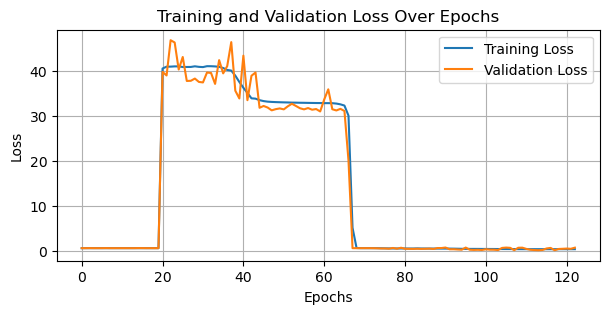

In [367]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

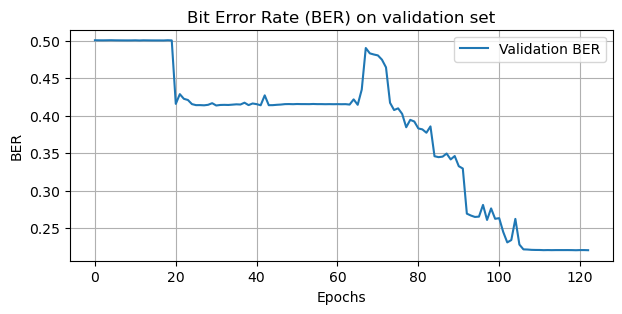

In [368]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [423]:
def evaluate_system(model, dataset, device):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  # Batch size can be adjusted
    model.eval()
    BER_batch = []
    with torch.no_grad():
        for data_batch in dataloader:
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels'].view(-1, 64, 256, 4)
            
            
            print(labels.shape)
            
            outputs = model(samples)
            binary_predictions = torch.round(outputs)  

            print(binary_predictions.shape)
            
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / labels.numel() 
            BER_batch.append(error_rate.item())
    
    BER_mean = np.mean(BER_batch)
    return BER_mean


In [424]:
bits_per_symbol_options = [2, 4, 6]  
snr_range = np.linspace(-5, 20, 6)  

for bits_per_symbol in bits_per_symbol_options:
    for snr_db in snr_range:
        
        dataset = ComplexDataset(num_bits_per_symbol=bits_per_symbol, DB_MIN=snr_db, DB_MAX=snr_db, totaldbs=1)
        
     
        BER_mean = evaluate_system(model, dataset, device)
        
        print(f"Bits-per-symbol: {bits_per_symbol}, SNR: {snr_db} dB, Mean BER: {BER_mean:.4f}")


Creating QAM constellation with 2 bits per symbol
(4,)
Creating QAM constellation with 2 bits per symbol
torch.Size([1, 64, 256, 4])


RuntimeError: shape '[1, 64, 256, 4]' is invalid for input of size 131072